### Sources and inspiration:
Emil Wallner blog post and code on Floydhub for image colorization

"Deep Koalarization": https://github.com/baldassarreFe/deep-koalarization

"Colorful Image Colorization": https://github.com/richzhang/colorization


## Setup Cells

### Compatibility: dependencies, Python 2 vs. 3

In [1]:
import sys

# Sometimes, some problems come up because the machine running this notebook
# doesn't have Keras, h5py, etc. We install those dependencies here.
! pip install keras
! pip install h5py

# Python 3 peculiarities
if sys.version_info[0] == 3:
    xrange = range

    100% |████████████████████████████████| 307kB 1.8MB/s 
    100% |████████████████████████████████| 4.8MB 228kB/s 


### Janitorial work
Cleaning up directories so we can start anew. Uncomment and run this only if you know you have data in these directories from a previous run, etc. that you want to remove and start anew.

In [2]:

# Look at the environment.
print("Current directory:\n")
! ls
print("\n=============\nUp one level:\n")
! ls ..

remove = False
if remove:
  ! rm -rf gif_train
  ! rm -rf metadata
  ! rm -rf model_params
  ! rm -rf ../data
  ! rm -rf ../results
  ! rm -rf tmp

  ! ls
  ! ls ..


Current directory:

datalab

Up one level:

bin	 dev			      lib    node_modules      root  srv    usr
boot	 etc			      lib64  opt	       run   sys    var
content  google-colab-0.0.1a1.tar.gz  media  proc	       sbin  tmp
datalab  home			      mnt    requirements.txt  srcs  tools


### Paths used in the model
Paths that we need are listed here.

In [3]:
import os

# Paths and utilities
# -------------------
# Assuming this notebook's directory (<repository root>/model) is root.
data_dir = "../data/"
train_dir = data_dir + "train/"
test_dir = data_dir + "test/"
results_dir = "../results/"
temp_dir = "tmp/"
gif_train_dir = temp_dir + "gif_train/"

model_chkpt = "model_params/"
model_metadata_dir = "metadata/"

required_directories = [
    train_dir,
    test_dir,
    results_dir,
    gif_train_dir,
    model_chkpt,
    model_metadata_dir
]


def create_unexisting_directories(dirs):
  for path in dirs:
    if not os.path.isdir(path):
      print("Didn't find the path '%s'. Creating it now." % path)
      # NOTE: os.makedirs() is recursive.
      os.makedirs(path)
    else:
      print("%s exists." % path)

create_unexisting_directories(required_directories)

Didn't find the path '../data/train/'. Creating it now.
Didn't find the path '../data/test/'. Creating it now.
Didn't find the path '../results/'. Creating it now.
Didn't find the path 'tmp/gif_train/'. Creating it now.
Didn't find the path 'model_params/'. Creating it now.
Didn't find the path 'metadata/'. Creating it now.


### Imports

In [4]:
import numpy as np
import random
import tensorflow as tf

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib
# This line was for some of our machines; some edge case
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

import keras
import keras.backend as K
from keras.activations import softmax
from keras.layers.core import RepeatVector
# Not sure we need all of these
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
#from keras.losses import categorical_crossentropy #same as K.categorical_crossentropy
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

Using TensorFlow backend.


### Pre-defined Constants, Global variables

In [0]:
model_name = "rainbownet"

# Adjustable constants
BATCH_SIZE = 16
N_EPOCHS = 1                 # default num epochs
GRID_SIZE = 8
NUM_TOTAL_BUCKETS = (256//GRID_SIZE)**2

NUM_VALID_BUCKETS = 394      # NUM_VALID_BUCKETS will be updated dynamically if inconsistent
BUCKET_ID_TO_INDEX = None    # helper dict for AB color discretization
BUCKET_INDEX_TO_ID = None    # helper dict for AB color discretization


## Populate our training directory with images
Run these cells if you want to download a gif and split into frames for training data.

- Downloading files from Google Drive
- Splitting GIF's into frames
- Output frames as images, into desired directory

In [0]:
# Getting a file from online
# --------------------------
# Taken from
# "https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive"
#
# example usage:
# download_file_from_google_drive("1H5aWTvlodzLA_hwm68BHtJbrvuKYt0hh", "test.jpg")

import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

    

In [0]:
# Turn our downloaded gif into images
# -----------------------------------

from PIL import Image
import urllib

def process_gif_and_save(file_path, save_dir):
    try:
        image = Image.open(file_path)
    except IOError:
        print("Can't load %s" % file_path)
        sys.exit(1)
    palette = image.getpalette()
    name = os.path.split(file_path)[-1].split('.')[0]

    # Double check to make sure path where we're saving it exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    try:
        i = 0
        while True:
            image.putpalette(palette)
            new_image = Image.new("RGB", image.size)
            new_image.paste(image)

            # This formats so we have "003-gif1.jpg" instead of "3-gif1.jpg". Works for <1000 images.
            image_id = str(i).rjust(3, "0")  
            frame_save_path = os.path.join(save_dir, image_id + "-" + name + '.jpg')
            
            new_image.save(frame_save_path)

            i += 1
            image.seek(image.tell() + 1)

    except EOFError:
        pass # end of sequence
    
    print("Finished processing gif. Saved to location '%s'" % file_path)

In [8]:

# Download a gif of a flying puppy and split it into frames
# Run this to populate train_dir with images, as a toy example.
# -------------------------------------------------------------

SAVE_DIR = train_dir
gif_location = gif_train_dir + 'gif1.gif'
gdrive_hash = "1ppGwWuu5J3ecEdwXJbBXzg4FOktbI1Cv"

download_file_from_google_drive(gdrive_hash, gif_location)
process_gif_and_save(gif_location, SAVE_DIR)

Finished processing gif. Saved to location 'tmp/gif_train/gif1.gif'


In [0]:
# Move some of the frames into test_dir so it has some content.
# -------------------------------------------------------------

! mv ../data/train/000-gif1.jpg ../data/test/000-gif1.jpg

### Let's see what we have so far.

We should see some files inside of the training and test data directories now.

Run the code below to display them and make sure they were obtained successfully.

In [10]:
# List out the directory contents
# -------------------------------

print("\nTest dir: \n---------")
! ls ../data/test

print("\nTrain dir: \n----------")
! ls ../data/train


Test dir: 
---------
000-gif1.jpg

Train dir: 
----------
001-gif1.jpg  010-gif1.jpg  019-gif1.jpg  028-gif1.jpg	037-gif1.jpg
002-gif1.jpg  011-gif1.jpg  020-gif1.jpg  029-gif1.jpg	038-gif1.jpg
003-gif1.jpg  012-gif1.jpg  021-gif1.jpg  030-gif1.jpg	039-gif1.jpg
004-gif1.jpg  013-gif1.jpg  022-gif1.jpg  031-gif1.jpg	040-gif1.jpg
005-gif1.jpg  014-gif1.jpg  023-gif1.jpg  032-gif1.jpg	041-gif1.jpg
006-gif1.jpg  015-gif1.jpg  024-gif1.jpg  033-gif1.jpg	042-gif1.jpg
007-gif1.jpg  016-gif1.jpg  025-gif1.jpg  034-gif1.jpg	043-gif1.jpg
008-gif1.jpg  017-gif1.jpg  026-gif1.jpg  035-gif1.jpg	044-gif1.jpg
009-gif1.jpg  018-gif1.jpg  027-gif1.jpg  036-gif1.jpg


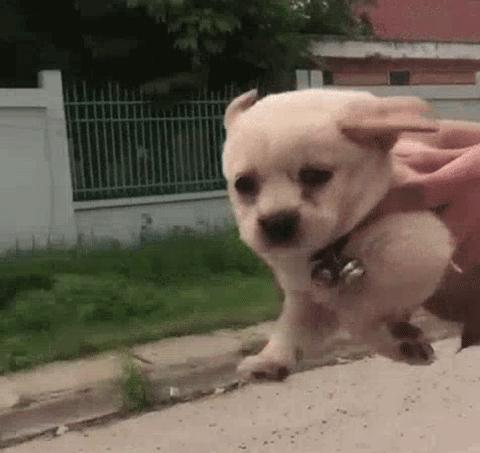

In [13]:
# What do the images look like? Let's sample one.
# -----------------------------------------------

from IPython.display import Image as iPyImage

# Change this to see different pictures
i = 10

image1 = os.listdir(train_dir)[i]
iPyImage(train_dir + image1)

## Helper Functions
Stuff we're using in the other functions below.

In [0]:
def resize_images(images, shape):
  """ Resizes images to a given shape.
      |shape|: a 3-tuple of the dimensions to resize to. 
               (H, W, 3) usually.
  """
  # Sanity check for dims
  assert len(shape) == 3 and shape[2] == 3
  
  resized = []
  for i in images:
    im = resize(i, shape, mode='constant')
    resized.append(im)
  resized = np.array(resized)
  return resized

In [0]:
# A debugging function.
def analyze_images(images):
  # 4d images
  L = images[:,:,:,0]
  A = images[:,:,:,1]
  B = images[:,:,:,2]
  print("stats on channel1: min %s, max %s" % (np.amin(L), np.amax(L)))
  print("stats on channel2: min %s, max %s" % (np.amin(A), np.amax(A)))
  print("stats on channel3: min %s, max %s" % (np.amin(B), np.amax(B)))

In [0]:
def debug(obj, name, plimit=500):
    typ = type(obj)
    typstr = str(typ)
    
    # for debugging ndarray shape or length of something
    shape = "(N/A)"
    if typ == type(np.array([0])):
      shape = obj.shape
    else:
      try:
        shape = "len=" + str(len(obj))
      except TypeError:
        pass
    shapestr = str(shape)

    objstr = str(obj)
    objout = objstr if len(objstr) < plimit else objstr[:plimit] + "\n[... %s output truncated]" % name
    
    outputs = [typstr, shapestr, name + ":\n", objout]
    print " ".join(outputs)

## Finding our color buckets
This is how we discretized the *ab* channels' color space into buckets for our model.


In [0]:
def get_bucket_id(ab_pixel):
    """ Given an ab coordinate, find the id of the bucket of
        that it belongs to.
        
        |ab_pixel|: np.array of shape (2,).
    """
    a = int(ab_pixel[0])
    b = int(ab_pixel[1])
    #print("We have a,b=%s" % (str((a,b))))
    
    bucket_row = (a + 128) // GRID_SIZE
    bucket_col = (b + 128) // GRID_SIZE
    bucket_id = bucket_row * (256 // GRID_SIZE) + bucket_col
    
    return bucket_id
  
def discretize_ab_space():
    # initialize a blank array of (# buckets, 2).
    space = np.zeros(((256//GRID_SIZE)**2, 2))
    
    bucket_index = 0
    for a in xrange(-128, 128, GRID_SIZE):
        for b in xrange(-128, 128, GRID_SIZE):
            a_mid = float(a + GRID_SIZE / 2)
            b_mid = float(b + GRID_SIZE / 2)
            space[bucket_index] = a_mid, b_mid
            bucket_index += 1

    return space

def compute_bucket_maps(bucket2ab_map=None, ab2bucket_map=None):
    
    # If we have 394 buckets, the bucket at the 177th index could be bucket #210.
    # These maps keep track of the index in [0, 394) <-> the bucket id.
    global BUCKET_ID_TO_INDEX
    global BUCKET_INDEX_TO_ID
    
    # 1) Get our monte carlo ab color space.
    # Note: skimage.color's rgb2lab takes in RGB values normalized to [0,1].
    # Step sizes of 3 for R,G,B is granular enough for our purposes,
    #   in sampling RGB space.
    all_rgb_normed = [[r/255., g/255., b/255.] for r in xrange(0,256) \
                                               for g in xrange(0,256) \
                                               for b in xrange(0,256)]
    print("compute_bucket_maps(): finished getting all_rgb_normed")
    
    NUM_RGB_SAMPLES = len(all_rgb_normed)
    all_rgb_normed = np.array(all_rgb_normed)
    all_rgb_normed = all_rgb_normed[:, np.newaxis, :]        # (#rgb colors, 1, 3=rgb)
    assert all_rgb_normed.shape == (NUM_RGB_SAMPLES, 1, 3) #  new axis because skimage demands it.
    ab_colors = rgb2lab(all_rgb_normed)                    # (#rgb colors, 1, 3=lab)
    ab_colors = np.squeeze(ab_colors)[:,1:]                # (#rgb colors, 2=ab)
    assert ab_colors.shape == (NUM_RGB_SAMPLES, 2)
    
    # 2) Get our buckets. 
    # ab_buckets[bucket #] = (a,b) coord for that bucket, even if it isn't a valid RGB.
    ab_buckets_centers = discretize_ab_space()             # (#buckets, 2=ab)
    assert ab_buckets_centers.shape == (NUM_TOTAL_BUCKETS, 2)
    
    # 3) Now we calculate the closest bucket for each ab color.
    closest = [get_bucket_id(color) for color in ab_colors]
    # closest = [np.argmin(np.linalg.norm(ab_buckets_centers - color, axis=1)) for color in ab_colors]
    valid_buckets = set(closest)
    
    # aside: for interpreting the softmax in the rainbowModel later, we need to know which neuron predicts which bucket
    BUCKET_ID_TO_INDEX = {bucket_id : i for i, bucket_id in enumerate(list(valid_buckets))}
    BUCKET_INDEX_TO_ID = {i : bucket_id for i, bucket_id in enumerate(list(valid_buckets))}
    debug(BUCKET_ID_TO_INDEX, "id to index", plimit=1000)
    debug(BUCKET_INDEX_TO_ID, "index to id", plimit=1000)
    
    # 4) Create the maps.
    bucket2ab_map = {bucket : tuple(ab_buckets_centers[bucket]) for bucket in valid_buckets}
    # Assert there are no repeats in the map
    assert len(bucket2ab_map.values()) == len(set(bucket2ab_map.values()))
    ab2bucket_map = {bucket2ab_map[bucket] : bucket for bucket in bucket2ab_map}
    assert len(ab2bucket_map.values()) == len(set(ab2bucket_map.values()))
    
    print ("There are %d final buckets." % len(bucket2ab_map))
    print ("There are %d final colors." % len(ab2bucket_map))
    
    return bucket2ab_map, ab2bucket_map

def plot_mapping(bucket2ab_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    for bucket in bucket2ab_map:
        a_mid = bucket2ab_map[bucket][0]
        a_low = a_mid - GRID_SIZE / 2
        b_mid = bucket2ab_map[bucket][1]
        b_low = b_mid - GRID_SIZE / 2

        lab_pixel = np.array([50., a_mid, b_mid])
        lab_pixel = np.reshape(lab_pixel, (1, 1, 3))
        rgb = tuple(lab2rgb(lab_pixel)[0][0])

        ax.add_patch(
            patches.Rectangle(
                (b_low, -a_low), 
                GRID_SIZE, 
                GRID_SIZE, 
                facecolor=rgb
            )
        )

    plt.xlim([-128, 128])
    plt.ylim([-128, 128])
    plt.show()

In [0]:
# Run this if you want to remove existing pickles, and recompute the maps.
remove = False
if remove:
  ! rm -f metadata/*.pkl
  ! ls metadata

compute_bucket_maps(): finished getting all_rgb_normed
<type 'dict'> len=394 id to index:
 {183: 0, 184: 1, 185: 2, 186: 3, 212: 4, 213: 5, 214: 6, 215: 7, 216: 8, 217: 9, 218: 10, 242: 11, 243: 12, 244: 13, 245: 14, 246: 15, 247: 16, 248: 17, 249: 18, 250: 19, 272: 20, 273: 21, 274: 22, 275: 23, 276: 24, 277: 25, 278: 26, 279: 27, 280: 28, 281: 29, 282: 30, 302: 31, 303: 32, 304: 33, 305: 34, 306: 35, 307: 36, 308: 37, 309: 38, 310: 39, 311: 40, 312: 41, 313: 42, 314: 43, 315: 44, 333: 45, 334: 46, 335: 47, 336: 48, 337: 49, 338: 50, 339: 51, 340: 52, 341: 53, 342: 54, 343: 55, 344: 56, 345: 57, 346: 58, 347: 59, 364: 60, 365: 61, 366: 62, 367: 63, 368: 64, 369: 65, 370: 66, 371: 67, 372: 68, 373: 69, 374: 70, 375: 71, 376: 72, 377: 73, 378: 74, 379: 75, 395: 76, 396: 77, 397: 78, 398: 79, 399: 80, 400: 81, 401: 82, 402: 83, 403: 84, 404: 85, 405: 86, 406: 87, 407: 88, 408: 89, 409: 90, 410: 91, 411: 92, 426: 93, 427: 94, 428: 95, 429: 96, 430: 97, 431: 98, 432: 99, 433: 100, 434: 101

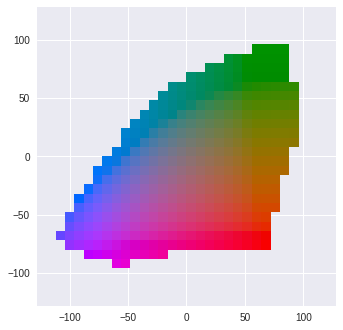

We have in the map 394 buckets.
Buckets loaded successfully!


In [19]:
"""
The script for loading our bucket maps.
If there are .pkl's of maps we've stored from a previous computation,
    load those.
Otherwise, run compute_bucket_maps() to get them, and dump into
    pickles for the future.
"""

# To open: `map = pickle.load(open(<filename>, 'r'))`
BUCKET2AB = model_metadata_dir + 'bucket2ab_map.pkl'
AB2BUCKET = model_metadata_dir + 'ab2bucket_map.pkl'

bucket2ab_map = None
ab2bucket_map = None

# No pickles found. Compute the maps.
if not os.path.isfile(BUCKET2AB) or not os.path.isfile(AB2BUCKET):
  bucket2ab_map, ab2bucket_map = compute_bucket_maps()
  
  pickle.dump(bucket2ab_map, open(BUCKET2AB, 'wb'))
  pickle.dump(ab2bucket_map, open(AB2BUCKET, 'wb'))
  
# We found the pickles! Load them.
else:
  print("Loading buckets from pickle.")
  bucket2ab_map = pickle.load(open(BUCKET2AB, 'rb'))
  ab2bucket_map = pickle.load(open(AB2BUCKET, 'rb'))

plot_mapping(bucket2ab_map)
# --------------------------

print("We have in the map %d buckets." % len(bucket2ab_map))
if NUM_VALID_BUCKETS != len(bucket2ab_map):
  print("NUM_VALID_BUCKETS=%s does not match the number of buckets we computed."
         % str(NUM_VALID_BUCKETS))
  print("Setting NUM_VALID_BUCKETS=%d" % len(bucket2ab_map))
  NUM_VALID_BUCKETS = len(bucket2ab_map)

print("Buckets loaded successfully!")

# bucket2ab_map: map of bucket # to (a, b)
# ab2bucket_map: map of (a, b) to bucket #
# use get_bucket(lab_pixel, ab2bucketmap) to get corresponding (a, b)

### Applying the Bucketing Scheme to Images
The following two functions are for turning an *Lab* image(s) into an array of bucket labels, and the converse.

In [0]:
def discretize(images_ab):
  """ This is a preprocessing step, that will be used in converting 
      Y (ab image true labels) into buckets, so that we can calculate
      a loss in colorization_loss().
  
      |images_ab|: (m, H, W, 2) array representing ab channels of images.
  
      :return: (m, H, W) array where each entry is in BUCKET_ID_TO_INDEX.
               One of the NUM_VALID_BUCKETS color buckets we found.
  """
  if len(images_ab.shape) == 3:
    print("discretize(): detected only 3 dims, reshaping to (m=1,:,:,:)")
    images_ab = images_ab[np.newaxis,:,:,:]
    
  assert BUCKET_ID_TO_INDEX is not None
  
  m, H, W, _ = images_ab.shape
  images_d = np.zeros((m, H, W))

  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        ab_pixel = images_ab[i,h,w]
        bucket_id = get_bucket_id(ab_pixel)
        images_d[i,h,w] = BUCKET_ID_TO_INDEX[bucket_id] # int in range [0, NVB)
  
  return images_d

# New name!
# ---------
ab_channels_to_bucket_indices = discretize

In [0]:
# This function will be called when we want to demo a predicted image.
# It takes an image with pixels labeled with buckets, and transforms it
#   into 2 color channels.

def inverse_discretize(images_d):
  """ The inverse of the above function. Maps the indicated bucket to
      the mean of that bucket.
      
      |images_d|: an array (m,H,W) with the color bucket *index=logit* 
                  assigned to each pixel.
                  
      :return: (m, H, W, 2) array with ab color values.
  """
  if len(images_d.shape) == 2:
    print("inverse_discretize(): detected only 2 dims, reshaping to (m=1,:,:)")
    images_d = images_d[np.newaxis,:,:]

  m, H, W = images_d.shape
  images_ab = np.zeros((m, H, W, 2))
  
  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        bucket_index = images_d[i,h,w]
        bucket_id = BUCKET_INDEX_TO_ID[bucket_index]
        images_ab[i,h,w] = bucket2ab_map[bucket_id] # Sets to [a,b]
  
  return images_ab

# New name!
# ---------
bucket_indices_to_ab_channels = inverse_discretize

## **The Inception ResNet Fusion**

We're going to be using Google's Inception ResNet v2 to augment our CNN. This model has been highly trained on millions of examples, and can detect features that would be useful in colorizing our test images. The fusion of IRNet features with our CNN will come later in RainbowNetModel(). For now, these functions load the model and set up predictions.



In [0]:
def load_inception_net():
  inception = InceptionResNetV2(weights='imagenet', include_top=True)
  inception.graph = tf.get_default_graph()
  return inception

In [0]:
def create_inception_embedding(grayscaled_rgb):
  """ One forward pass through the Inception ResNet.
      
      |grayscaled_rgb|: the images we are embedding in grayscale. 
      
      :return: (m, 1000) vector.
  """
  # Resize all the images to (299, 299, 3).
  grayscaled_rgb_resized = resize_images(grayscaled_rgb, (299, 299, 3))

  # preprocessing for the Inception resnet
  grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

  # Predict.
  with inception.graph.as_default():
    embed = inception.predict(grayscaled_rgb_resized)
  
  return embed

In [27]:
# Get the weights for inception resnet if we don't have them
"""
weights_path = model_metadata_dir + "inception_resnet_v2_weights.h5"
weights_id = "1L9cHTdvBocGHi-SJmgR_27ak6OPudJDc"
if not os.path.isfile(weights_path):
  print ("Didn't find the inception resnet weights. Downloading them.")
  download_file_from_google_drive(weights_id, weights_path)
"""
# Deprecated: Can automatically get weights from Keras.

  
# initialize inception resnet, for use in |preprocess_data()|
# -----------------------------------------------------------
try:
    assert type(inception) == keras.engine.training.Model
except (NameError, AssertionError):  
    inception = load_inception_net()

    
print ("Loaded Inception Resnet model for generating image embeddings.")


225222656/225209952 [==============================] - 6s 0us/step
Loaded Inception Resnet model for generating image embeddings.


## Loading data for Baseline and RainbowNet
The function to load data.

In [0]:
# Examples of use:
# load_data(train_dir)
# load_data(test_dir)

def load_data(directory):
    """ Load an entire set of |m| examples. If loading entire dataset takes
      too much memory, may have to run in batches: 
      train, save chkpt.
      Put new examples in the directory.
      Repeat. 
    """
    images = []
    for filename in os.listdir(directory):
      image = load_img(directory + filename)  # PIL image
      images.append(img_to_array(image))      # np.array

    images = np.array(images, dtype=float)
    return images
  

## Getting/processing the data for RainbowNet
These are the functions that load the data, for training and for test.

```preprocess_data()``` then processes them for input into our CNN. This involves converting to *Lab* and separating the channels, running through InceptionResnet, and normalizing the *L* channel input.

In [0]:
def preprocess_data(images):
    """ Preprocess the data for input into our rainbownet model.
    """
    
    print("preprocess_data(): obtained %d images." % len(images))

    #analyze_images(images)
    # Resize them to (224,224)
    print("preprocess_data(): Resizing")
    images_resized = resize_images(images, (224, 224, 3))
    
    # Get the inception embeddings from grayscaled images. 
    #   This will be part of our passed in input.
    print("preprocess_data(): Creating inception embeddings")
    grayscaled_images = gray2rgb(rgb2gray(images_resized))
    embs = create_inception_embedding(grayscaled_images) # a numpy array

    # Normalize the resized images (which are in RGB) to [0,1] to prepare for rgb2lab.
    images_normed = images_resized - np.amin(images_resized, axis=(1,2), keepdims=True)
    images_normed = images_normed / np.amax(images_normed, axis=(1,2), keepdims=True)
    #analyze_images(images_normed)
    
    # Transform to lab. Separate the l- and ab- channels
    print("preprocess_data(): Separating L and ab channels")
    images_lab = rgb2lab(images_normed)
    #analyze_images(images_lab)
    images_l = images_lab[:,:,:,0,np.newaxis]     # shape (m, H, W, n_frames=1 for now)
    images_ab = images_lab[:,:,:,1:]              # shape (m, H, W, 2) 
    
    # Normalize L channel to be between 0, 1.
    print("preprocess_data(): Normalizing L channel to [0,1]")
    bottom = np.amin(images_l, axis=(1,2), keepdims=True)
    images_l -= bottom
    top = np.amax(images_l, axis=(1,2), keepdims=True)
    images_l /= top

    # Create X, composed of L channel + the embedding
    X_images = images_l
    X_embeds = embs

    # Create Y, including discretizing the ab image
    print("preprocess_data(): discretizing Y")
    Y = discretize(images_ab)       # shape (m, H, W)
    
    print("preprocess_data(): done. returning X_img, X_emb, Y")
    return X_images, X_embeds, Y

## Defining our per-pixel softmax loss
Our colorization loss is the softmax cross-entropy between the multinomial color distributions of every pixel in ```y_true``` and ```y_pred``` over all pixels (H,W), over all images in the minibatch. Inspired by the colorization paper, to solve issues other losses like desaturation from MSE.



In [0]:
# Deprecated. Keras doesn't like this, I'm guessing it doesn't know how to backprop through our custom function and is complaining
# Better soln below.
"""
def homemade_to_categorical(y):
    #shape (m, 224, 224)
    m, H, W = y.shape
    categorical = np.zeros((m, H, W, NUM_VALID_BUCKETS))
    for i in xrange(m):
      for h in xrange(H):
        for w in xrange(W):
          index = int(y[i,h,w])
          categorical[i,h,w,index] = 1.
    return categorical


def homemade_to_categorical(y):
  debug(np.max(y)+1, "max in y")
  assert np.max(y) + 1 == NUM_VALID_BUCKETS
  m, H, W = y.shape
  
  categorical = np.zeros(y.shape + (NUM_VALID_BUCKETS))
  
  for i in xrange(m):
    logit_vals = y[i]
    Hlist = [num / W for num in range(H*W)]
    Wlist = list(range(W)) * H
    categorical[i, Hlist, Wlist, y] = 1
    
  return categorical
"""

In [0]:
def colorization_loss(y_true, y_pred):
  """ |y_true|: Our true colors. A tensor (batch_size, H, W) with entries 
                specifying one of the buckets that pixel's color is in.
      |y_pred|: A (batch_size, H, W, NUM_VALID_BUCKETS) tensor with last dimension a
                softmax over bucket probabilities.
  
      This loss involves computing the softmax cross-entropy over pixel's
        predicted color bucket, over all images in the batch.
  """
  #   TODO: implement color weighting, like in Richard Zhang et al.
  #------
  
  #TODO FIX BUG: extract y_true out of the zero padding with tf.slice
  # See comments in the training the model cell a couple of cells down
  # because...
  # The Problem
  # ------------
  # Keras forces any custom loss we write to take 2 tensors of same dims which is stupid
  # rn, our y_true = (m, 224, 224) and y_pred = (m, 224, 224, 394) so Keras is complaining
  # the lines below calculate a loss even when keeping y_true as logits which is great
  # I'm trying to find a way to get around this enforcement of same dims
  # One solution is to pass our labels as an input, actually
  # See the "compile and fit the model" cell for a link to the Keras github issue that talks about this
  # Best case scenario: Don't even need a custom loss, just somehow do tf.reduce_sum(K.sparse_...())
  #    without breaking out a custom function and causing this whole headache
  
  xentropy_losses = K.sparse_categorical_crossentropy(y_true, y_pred) # (m, H, W) Xentropy along last dimension
  # TODO: weight by predicted colors, so results aren't desaturated?
  return tf.reduce_sum(xentropy_losses) # aggregate xentropy summed over m, H, W
  

## Defining our RainbowNet model


In [47]:
def RainbowNetModel():
  # THE MEAT OF THE CODE
  # Inspired by the colorization paper's architecture. Keep in mind they trained
  #   on ImageNet though.
  
  # Input will have to be modified for doing image seqs. 
  #   In particular the volume is probably not 1 channel, but n_frames channels.
  embedding_input = Input(shape=(1000,), name='embed_input')
  encoder_input = Input(shape=(224, 224, 1,), name='image_input')

  # NOTE: The number of times we do "strides=2" is the 
  #   same as the number of times we do Upsampling2D. 
  
  # Encoder
  # -------
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='enc_1-1')(encoder_input)
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='enc_1-2down')(encoder_input) #112
  encoder_output = BatchNormalization(name='enc_1-bn')(encoder_output)
  
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='enc_2-1')(encoder_output)
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2, name='enc_2-2down')(encoder_output) #56
  encoder_output = BatchNormalization(name='enc_2-bn')(encoder_output)
  
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='enc_3-1')(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2, name='enc_3-2down')(encoder_output) #28
  encoder_output = BatchNormalization(name='enc_3-bn')(encoder_output)
  
  # May have to reduce layers if we don't have enough training data, to avoid overfitting.
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='enc_4-1')(encoder_output)
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='enc_4-2')(encoder_output)
  encoder_output = BatchNormalization(name='enc_4-bn')(encoder_output)


  # Fusion
  # ------
  fusion_output = RepeatVector(28 * 28, name='fuse_repeat')(embedding_input) 
  fusion_output = Reshape(([28, 28, 1000]), name='fuse_reshape')(fusion_output)
  fusion_output = concatenate([encoder_output, fusion_output], axis=3, name='fuse_concat')  # Stack along thickness dimension
  
  # A volume that solidifies the fusion from the inception-resnet vectors + our previous volume:
  fusion_output = Conv2D(512, (1, 1), activation='relu', padding='same', name='fuse_conv2d')(fusion_output) 


  #Decoder
  # May have to reduce layers if we don't have enough training data, to avoid overfitting.
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='dec_1-1')(fusion_output) # 28
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='dec_1-2')(decoder_output)
  decoder_output = BatchNormalization(name='dec_1-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_1-up')(decoder_output) # 56
  
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_2-1')(decoder_output)
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_2-2')(decoder_output)
  decoder_output = BatchNormalization(name='dec_2-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_2-up')(decoder_output) # 112
  
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='dec_3-1')(decoder_output)
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='dec_3-2')(decoder_output)
  decoder_output = BatchNormalization(name='dec_3-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_3-up')(decoder_output) # 224
  
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_4-1')(decoder_output)
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='dec_4-2')(decoder_output)
  
  # BUGGY???
  #def softmax_for_rainbownet(x):
  #  return softmax(x, axis=2)

  softmax_output = Conv2D(NUM_VALID_BUCKETS, (3,3), activation=softmax, padding='same', name='dec_5_final_output')(decoder_output)
  
  model = Model(inputs=[encoder_input, embedding_input], outputs=softmax_output)
  return model

rainbowModel = RainbowNetModel()
rainbowModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
enc_1-2down (Conv2D)            (None, 112, 112, 64) 640         image_input[0][0]                
__________________________________________________________________________________________________
enc_1-bn (BatchNormalization)   (None, 112, 112, 64) 256         enc_1-2down[0][0]                
__________________________________________________________________________________________________
enc_2-1 (Conv2D)                (None, 112, 112, 128 73856       enc_1-bn[0][0]                   
__________________________________________________________________________________________________
enc_2-2dow

### Saving and loading this model

In [0]:
def save_model(model, model_save_path):
  model_json = model.to_json()
  with open(model_save_path + model_name + ".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(model_save_path + model_name + ".h5")

In [0]:
def load_existing_model():
  weights_path = model_chkpt + model_name + ".h5"

  if not os.path.isfile(weights_path):
    print("The model at path %s was not found." % weights_path)
    quit()
    
  model = RainbowNetModel()
  rainbowModel.load_weights(weights_path)
  return model

## Time to train our RainbowNet model!
Now we can run our model. It will save its parameters after every training session.

If you're looking to only predict, run the cell after this.

### Load and preprocess the data

In [0]:
display = False
if display:
  print(train_dir)
  ! ls ../data/train
  
X_train_img = None
X_train_emb = None
Y_train = None
X_test_img = None
X_test_emb = None
Y_test = None

In [39]:
images_train = load_data(train_dir)
X_train_img, X_train_emb, Y_train = preprocess_data(images_train)
print ("Loaded training data.\n==========")

images_test = load_data(test_dir)
X_test_img, X_test_emb, Y_test = preprocess_data(images_test)
# We are going to test on train for now to sanity check.
#X_test, Y_test = X_train, Y_train
print ("Loaded test data.\n==========")

preprocess_data(): obtained 44 images.
preprocess_data(): Resizing
preprocess_data(): Creating inception embeddings
preprocess_data(): Separating L and ab channels
preprocess_data(): Normalizing L channel to [0,1]
preprocess_data(): discretizing Y
preprocess_data(): done. returning X, Y
Loaded training data.
preprocess_data(): obtained 1 images.
preprocess_data(): Resizing
preprocess_data(): Creating inception embeddings
preprocess_data(): Separating L and ab channels
preprocess_data(): Normalizing L channel to [0,1]
preprocess_data(): discretizing Y
preprocess_data(): done. returning X, Y
Loaded test data.


### Compile and fit the model

In [54]:
# Run the model!
with tf.Session() as sess:
  
  try: # We might have already instantiated the model earlier in the definition cell for a summary.
    rainbowModel
  except NameError:
    rainbowModel = RainbowNetModel()

  rainbowModel.compile(optimizer='adam', 
                       loss=colorization_loss)
  
  # TODO: haaaaacky thing, we gotta feed in Y_train as an input...? or else pad with all 0's and then extract what we
  #  actually want later, but that gives us the same huge memory size problem
  # ValueError: Error when checking target: expected dec_5_final_output to have 4 dimensions, but got array with shape (44, 224, 224)

  # Read this thread: they have the hacky labels-as-inputs soln.
  # -----------------
  # https://github.com/fchollet/keras/issues/4781
  rainbowModel.fit({'image_input': X_train_img, 'embed_input': X_train_emb}, # X
                   {'dec_5_final_output': Y_train}, # Y
                   epochs=2,
                   batch_size=BATCH_SIZE)

  save_model(rainbowModel, model_chkpt)

  # Get predictions after we've trained.
  predictions = rainbowModel.evaluate(X_test, Y_test)


ValueError: ignored

## Displaying our predictions afterwards
The predictions are (m, H, W, NUM_VALID_BUCKETS), where the last dimension is the softmax vector. We need to process these so they're interpretable as color images.

In [0]:
# The predictions are (m, H, W, NUM_VALID_BUCKETS = softmax dim).
# We need to process these so they're interpretable as color images.
m, H, W, _ = predictions.shape
predicted_bucket_indices = np.argmax(predictions, axis=3)

# Display / output the predictions.
output_images_ab = inverse_discretize(predicted_buckets)
output_images_lab = np.concatenate((X_test, output_images_ab), axis=3) # add the L channel back

# save one image
image = output_images_lab[0]
image_rgb = lab2rgb(image)
imsave(results_dir + "rainbow_img.jpg", image_rgb)

from IPython.display import Image 

# Display what we have in results_dir.
for filename in os.listdir(results_dir):
  print filename
  display(Image(results_dir + filename))

## Baseline for comparison: processing, model, and training

We implemented a simple baseline for comparison. 2 layer FCNN.

In [0]:
# def preprocess_baseline_data(images):
#     images_resized = resize_images(images, (224, 224, 3))
#     debug(images_resized, "resized")
#     images_resized_scaled = 1.0/255 * images_resized
#     debug(images_resized_scaled, "scaled")
#     images_lab = rgb2lab(images_resized_scaled)
#     debug(images_lab, "lab")
    
#     X = images_lab[:,:,:,0] # / 128.
#     debug(X, "X")
#     Y = images_lab[:,:,:,1:] / 128.
#     debug(Y, "Y")
    
#     X = X.reshape((len(X), np.prod(X.shape[1:])))
#     Y = Y.reshape((len(Y), np.prod(Y.shape[1:])))
#     return X, Y
 
# milestone
def preprocess_baseline_data(images):
    images_resized = resize_images(images, (224, 224, 3))
    X = rgb2lab(1.0 / 255 * images_resized)[:,:,:,0]
    Y = rgb2lab(1.0 / 255 * images_resized)[:,:,:,1:] / 128.
    
    X = X.reshape((len(X), np.prod(X.shape[1:])))
    Y = Y.reshape((len(Y), np.prod(Y.shape[1:])))
    return X, Y

In [0]:
# def BaselineModel():
#     inputs = Input(shape=(224 * 224,))
#     encoded = Dense(224, activation='relu')(inputs)
#     decoded = Dense(224 * 224 * 2, activation='tanh')(encoded)
#     return Model(inputs, decoded)
  
  
def BaselineModel():
    inputs = Input(shape=(224 * 224,))
    encoded = Dense(224, activation='relu')(inputs)
    decoded = Dense(224 * 224 * 2, activation='tanh')(encoded)
    return Model(inputs, decoded)

In [45]:
# # Load the training data
# images_train = load_data(test_dir) # CHANGE TO train_dir LATER
# X_train, Y_train = preprocess_baseline_data(images_train)
# # print("Loaded X_train " + str(X_train.shape))
# # print("Loaded Y_train " + str(Y_train.shape))


# # Load the test data
# images_test = load_data(test_dir)
# X_test, Y_test = preprocess_baseline_data(images_test)
# X_test *= 128
# # print("Loaded X_test " + str(X_test.shape))
# # print("Loaded Y_test " + str(Y_test.shape))

# from keras import optimizers

# # Initialize our baseline model, and train it
# baselineModel = BaselineModel()
# baselineModel.compile(optimizer='sgd', loss='mean_squared_error')
# baselineModel.fit(x=X_train, y=Y_train, batch_size=2, epochs=5)

# # print('===')

# # Evaluate on the test set, and print our loss.
# # print baselineModel.evaluate(X_test, Y_test, batch_size=1)
# test_output = baselineModel.predict(X_test) # * 128 * 128 * 128

# # debug(test_output[0], "test_output")   # The (224*224*2)-vector that the baseline predicted from X_test[0]
# # debug(Y_test[0], "Y_test")             # The ground truth, Y_test[0], corresponding to it.



# # Save the results of prediction (in test_output) into the results_dir.
# num_test_examples = len(X_test)
# for i in range(num_test_examples):
#     # The empty array holding our formatted-into-a-picture result
#     cur = np.zeros((224, 224, 3))
#     cur[:,:,0] = X_test[i].reshape((224, 224))                        # Set the L channel
    
#     cur[:,:,1:] = test_output[i].reshape((224, 224, 2)) * 128         # Set the ab channels as our prediction
#     test_output_rgb = lab2rgb(cur)
#     imsave(results_dir + "img_" + str(i) + ".png", test_output_rgb)   # Save it.
    
#     cur[:,:,1:] = Y_test[i].reshape((224, 224, 2)) * 128              # Set the ab channels as ground truth
#     Y_test_rgb = lab2rgb(cur)
#     imsave(results_dir + "img_" + str(i) + "_og.png", Y_test_rgb)     # Save it too.
    
# from matplotlib import pyplot as plt
# # directly show an image from a variable
# plt.imshow(Y_test_rgb)
# plt.imshow(test_output_rgb)

# Load the training data
images_train = load_data(test_dir) # CHANGE TO train_dir LATER
X_train, Y_train = preprocess_baseline_data(images_train)
print("Loaded X_train " + str(X_train.shape))
print("Loaded Y_train " + str(Y_train.shape))

# Load the test data
images_test = load_data(test_dir)
X_test, Y_test = preprocess_baseline_data(images_test)
print("Loaded X_test " + str(X_test.shape))
print("Loaded Y_test " + str(Y_test.shape))

# Initialize our baseline model, and train it
baselineModel = BaselineModel()
baselineModel.compile(optimizer='sgd', loss='mean_squared_error') #param: lr=12345.
baselineModel.fit(x=X_train, y=Y_train, batch_size=2, epochs=5)

print('===')

# Evaluate on the test set, and print our loss.
print baselineModel.evaluate(X_test, Y_test, batch_size=1)
test_output = baselineModel.predict(X_test) * 128 * 128 * 128

# debug(test_output[0], "test_output")   # The (224*224*2)-vector that the baseline predicted from X_test[0]
# debug(Y_test[0], "Y_test")        # The ground truth, Y_test[0], corresponding to it.

# Save the results of prediction (in test_output) into the results_dir.
num_test_examples = len(X_test)
for i in range(num_test_examples):
    # The empty array holding our formatted-into-a-picture result
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = X_test[i].reshape((224, 224))                        # Set the L channel
    cur[:,:,1:] = test_output[i].reshape((224, 224, 2)) * 128         # Set the ab channels as our prediction
    imsave(results_dir + "img_" + str(i) + ".png", lab2rgb(cur))      # Save it.
    cur[:,:,1:] = Y_test[i].reshape((224, 224, 2)) * 128              # Set the ab channels as ground truth
    imsave(results_dir + "img_" + str(i) + "_og.png", lab2rgb(cur))   # Save it too.

Loaded X_train (1, 50176)
Loaded Y_train (1, 100352)
Loaded X_test (1, 50176)
Loaded Y_test (1, 100352)
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.7991
Epoch 2/5
1/1 [==============================] - 0s 276ms/step - loss: 0.6187
Epoch 3/5
1/1 [==============================] - 0s 312ms/step - loss: 0.0069
Epoch 4/5
1/1 [==============================] - 0s 309ms/step - loss: 0.0067
Epoch 5/5
1/1 [==============================] - 0s 284ms/step - loss: 0.0067
===
1/1 [==============================] - 0s 103ms/step
0.0067324321717


/usr/local/lib/python2.7/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 15 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


img_0_og.png


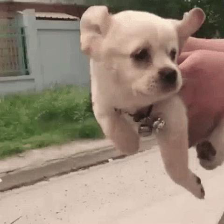

img_0.png


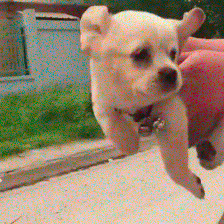

In [46]:
from IPython.display import Image

# Display what we have in results_dir.

for filename in os.listdir(results_dir):
  print filename
  display(Image(results_dir + filename))


In [67]:
test_output

array([[ 0.00577084,  0.01801091,  0.01894212, ..., -0.0298143 ,
         0.03247843, -0.03496474]], dtype=float32)

## Predict using RainbowNet
If you don't want to train, but only use the saved model to predict something, run this cell.

In [0]:
X_test, Y_test = load_data(test_dir)

rainbowModel = load_existing_model()

predictions = rainbowModel.evaluate(X_test, Y_test)

# Display / output the predictions.
# 
